# SISPS-AST9AH-EIS

Main root file for analysis of SISPS-AST9AH-EIS experiment.

[Lawrence Stanton](mailto:lawrence.stanton@uct.ac.za)

- _Began_ March 2024
- _Revised_ June 2024


## Top-Level Configuration

Environmental configuration, including default properties for major packages used, and default naming variables.


In [1]:
import importlib
import sys

REQUIRED_PACKAGES = ['matplotlib', 'numpy', 'pandas', 'regex']

for package in REQUIRED_PACKAGES:
    try:
        module = importlib.import_module(package)
        version = module.__version__
        print(f"{package} ({version}) is already installed.")
    except ImportError:
        print(f"{package} is NOT installed. Installing now...")
        %pip install {package}


print(f"System Version: {sys.version}")


matplotlib (3.9.0) is already installed.
numpy (1.26.4) is already installed.
pandas (2.2.2) is already installed.
regex (2.5.145) is already installed.
System Version: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:50:49) [Clang 16.0.6 ]


In [2]:
import matplotlib.pyplot as plt

# Modify default plotting style
plt.style.use('dark_background')  # <--- comment toggle per visual preference

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (8, 5)
%config InlineBackend.figure_formats = ['svg']

nyquistRealAxisLabel = 'Real Impedance (mΩ)'
nyquistImagAxisLabel = 'Imaginary Impedance (mΩ)'


## Electrochemical Impedance Spectroscopy (EIS) Data Import

Importing raw data from the EIS experiment, and converting it into a format that can be used for analysis.

A subset of files are final test data files, filtered manually during the experiment. All other test files are collected under `All` (including duplicates of final test files). These may be run for some basic analysis but not all.

In [3]:
from eisImport import findMainEisFiles, findAllEisFiles, readEisFiles

eisDirectory = "../Data/EIS"
eisFiles = findMainEisFiles(eisDirectory)
eisRaw = readEisFiles(tuple(eisFiles))

eisAllFiles = findAllEisFiles(eisDirectory)
eisRawAll = readEisFiles(tuple(eisAllFiles))


### Raw EIS Plots

Plots all EIS spectra individually. This is useful for visual inspection of the raw data.

Plots are saved under the `Plots` directory and are only generated once based on the existence of the target directories (which are not committed to the repository ala `.gitignore`). To regenerate the plots, delete the `Plots` directory and rerun this cell.

Overlaid plot of all tests is also generated for a quick visual comparison of all tests and reference against preprocessing.

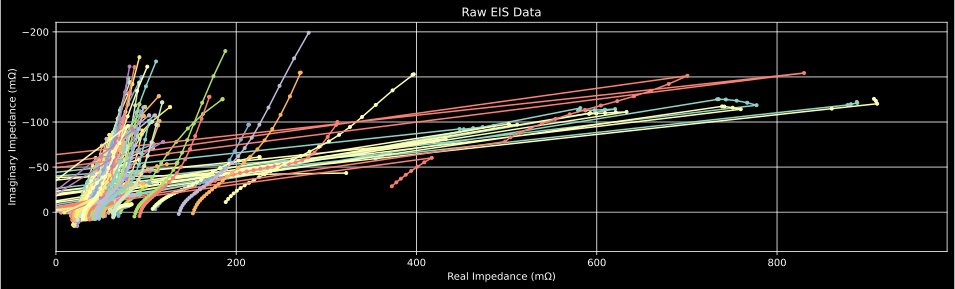

In [4]:
import os
import concurrent.futures
from typing import Dict

from eisImport import EisData
from eisPlot import plotNyquist


def plotIndividualNyquist(eisData: Dict[str, EisData], saveDir, scatter=False) -> None:
    """
    Plots individual Nyquist plots for each EIS data set in the dictionary.

    Args:
        eisData (dict): A dictionary containing EIS data sets.
        saveDir (str): The directory where the plots will be saved.
        scatter (bool, optional): Whether to include scatter points in the plot. Defaults to False.

    Returns:
        None

    This function is parallelized to speed up the plotting process and is intended for long dictionaries only.

    If the specified save directory does not exist, it will be created. If it already exists, the function will skip the plotting process (speeds up re-runs).
    """
    if os.path.exists(saveDir) == False:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for eis in eisData:
                executor.submit(
                    plotNyquist,
                    {eis: eisData[eis]},
                    saveDir=saveDir,
                    scatter=scatter,
                    transparent=True,
                )


individualRawEisPlotConfig = [
    {
        "eisData": eisRaw,
        "saveDir": "../Plots/EIS/Raw/Main",
        "scatter": False,
    },
    {
        "eisData": eisRawAll,
        "saveDir": "../Plots/EIS/Raw/All",
        "scatter": False,
    },
]

for config in individualRawEisPlotConfig:
    plotIndividualNyquist(**config)

rawEisPlotFigure = plotNyquist(
    eisRaw,
    title="Raw EIS Data",
)
plt.legend().remove()


### Preprocessing

#### Erroneous Point Removal

Some plots contain points that are clearly erroneous and were tolerated due to the experiment time and temperature control constraints. In general, only single outliers in sequence are accepted (although there are some exceptions to this). This preprocessing step removes these points.

2 main erroneous modes were identified:

1. **50/100Hz Noise Issues**  
   Some spectra have outlying points at near 50Hz and 100Hz frequencies. This is likely due to an issue in the power supply (for which significant electronic effort in the Digatron design was made to mitigate). Without changing measurement channels (which would introduce other offsets), these points were tolerated.
2. **DSP Garbage In / Garbage Out**  
   Some batteries may have produced response signals that were not properly filtered or otherwise accepted by the Digatron DSP pipeline when computing impedance values. Often these are obvious due to negative real impedance values (which are impossible in reality).

The preprocessing step removes these points. Details of the removal are documented in the responsible functions.


Filtered 4 negative real points from UCT_AST_A10_-20 RUN 2
Filtered 6 negative real points from UCT_AST_A10_-20 RUN 1
Filtered 3 negative real points from UCT_AST_B10_-20
Filtered 1 negative real points from UCT_AST_B09_+00
Filtered 1 negative real points from UCT_AST_B07_+RT2
Filtered 2 negative real points from UCT_AST_B05_+RT2
Filtered 3 negative real points from UCT_AST_B05_-40 2
Filtered 2 negative real points from UCT_AST_B05_-40 1
Filtered 1 negative real points from UCT_AST_B05_-40 3


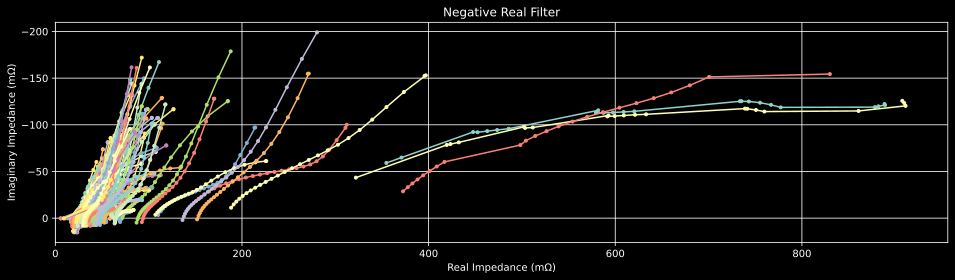

In [5]:
from eisPreprocess import filterNegativeReal

eisNegRealProcessed = filterNegativeReal(eisRaw)

plotIndividualNyquist(
    eisNegRealProcessed,
    "../Plots/EIS/Processed/NegRealFilter/Main",
    False,
)

plotNyquist(
    eisNegRealProcessed,
    title="Negative Real Filter",
)
plt.legend().set_visible(False)
plt.show()


Filtered 1 outliers from UCT_AST_B07_-10 at frequencies [53.333]Hz
Filtered 1 outliers from UCT_AST_B05_-20 at frequencies [94.862]Hz
Filtered 1 outliers from UCT_AST_B09_+00 at frequencies [71.217]Hz
Filtered 1 outliers from UCT_AST_B05_-40 1 at frequencies [66.667]Hz


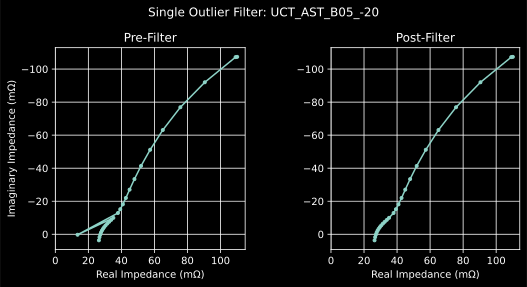

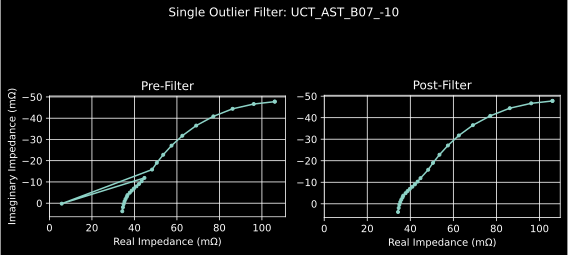

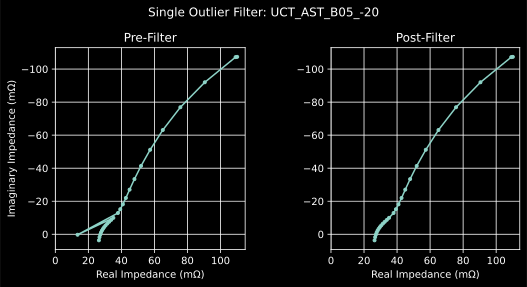

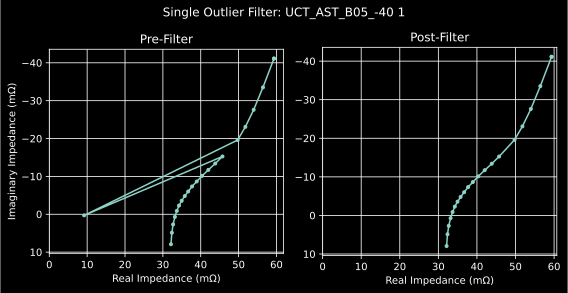

In [6]:
from eisPreprocess import filterSingleOutlier

knownExampleSpectra = [
    "UCT_AST_B05_-20",
    "UCT_AST_B07_-10",
    "UCT_AST_B05_-20",
    "UCT_AST_B05_-40 1",
]

eisSingleOutlierProcessed = filterSingleOutlier(eisNegRealProcessed)

for eis in knownExampleSpectra:
    fig, ax = plt.subplots(1, 2, figsize=(16, 9))

    fig.suptitle(f"Single Outlier Filter: {eis}")

    ax0 = plotNyquist(
        {eis: eisNegRealProcessed[eis]},
        title=f"Pre-Filter",
        figsize=(8, 4),
        ax=ax[0],
    )
    assert ax0 is not None
    ax0.legend().set_visible(False)

    ax1 = plotNyquist(
        {eis: eisSingleOutlierProcessed[eis]},
        title=f"Post-Filter",
        figsize=(8, 4),
        ax=ax[1],
    )
    assert ax1 is not None
    ax1.legend().set_visible(False)
    ax1.set_ylabel("")

    fig.tight_layout()


plotIndividualNyquist(
    eisSingleOutlierProcessed,
    "../Plots/EIS/Processed/SingleOutlierFilter/Main",
    False,
)

plt.legend().set_visible(False)
plt.show()


### Renaming

While there was an attempt to standardize the naming of the files, there are still some inconsistencies. This step renames the files to a consistent format, given sufficient matching information in the current input.

Additionally, the dictionary is sorted by key name.


In [7]:
from eisPreprocess import renameLabels

eisRenamed = renameLabels(eisSingleOutlierProcessed)
eisRenamed = dict(sorted(eisRenamed.items()))


Rename: ➤ UCT_AST_9AH_A08_+RT       ➤ UCT_AST9AH_A08_RT1
Rename: ➤ UCT_AST_9AH_A05_+RT       ➤ UCT_AST9AH_A05_RT1
Rename: ➤ UCT_AST_9AH_A02_+RT       ➤ UCT_AST9AH_A02_RT1
Rename: ➤ UCT_AST_9AH_A07_+RT       ➤ UCT_AST9AH_A07_RT1
Rename: ➤ UCT_AST_9AH_A04_+RT       ➤ UCT_AST9AH_A04_RT1
Rename: ➤ UCT_AST_9AH_A03_+RT1      ➤ UCT_AST9AH_A03_RT1
Rename: ➤ UCT_AST_9AH_A09_+RT       ➤ UCT_AST9AH_A09_RT1
Rename: ➤ UCT_AST_9AH_A10_+RT       ➤ UCT_AST9AH_A10_RT1
Rename: ➤ UCT_AST_9AH_A06_+RT       ➤ UCT_AST9AH_A06_RT1
Rename: ➤ UCT_AST_9AH_A01_+RT       ➤ UCT_AST9AH_A01_RT1
Rename: ➤ UCT_AST_A04_-10           ➤ UCT_AST9AH_A04_-10
Rename: ➤ UCT_AST_A05_-10           ➤ UCT_AST9AH_A05_-10
Rename: ➤ UCT_AST_A10_-10           ➤ UCT_AST9AH_A10_-10
Rename: ➤ UCT_AST_A07_-10           ➤ UCT_AST9AH_A07_-10
Rename: ➤ UCT_AST_A06_-10           ➤ UCT_AST9AH_A06_-10
Rename: ➤ UCT_AST_A03_-10           ➤ UCT_AST9AH_A03_-10
Rename: ➤ UCT_AST_A08_-10           ➤ UCT_AST9AH_A08_-10
Rename: ➤ UCT_AST_A09_-10      

#### Validation

Final check to confirm all data present and accounted for. This is a simple check to ensure that all files have been processed and renamed correctly.

In [8]:
# Rename variable before moving forward
eis = eisRenamed


### Analysis

This section contains general analysis of the EIS data, including:

- **Constant Temperature, Varied SoC**  
  Analysis of the impedance spectra at a constant temperature and varied state of charge.
- **Constant SoC, Varied Temperature**  
  Analysis of the impedance spectra at a constant state of charge and varied temperature.
- **Batch A Before-After Room Temperature**  
  Analysis of the impedance spectra for Batch A before and after room temperature cycling.
- **Batch A vs Batch B Comparisons**  
  Analysis of the impedance spectra for Batch A and Batch B at the same state of charge and temperature.


#### Constant SoC, Varied Temp

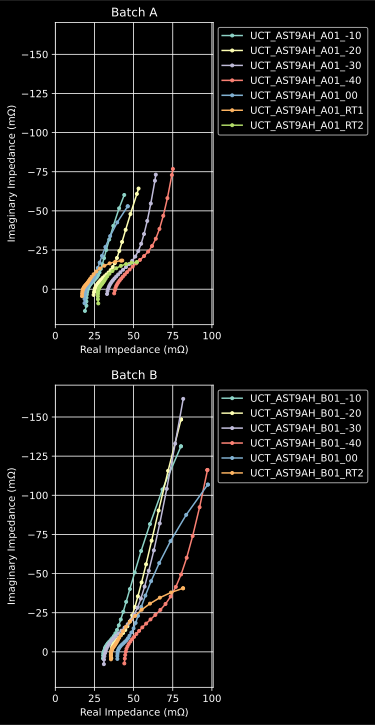

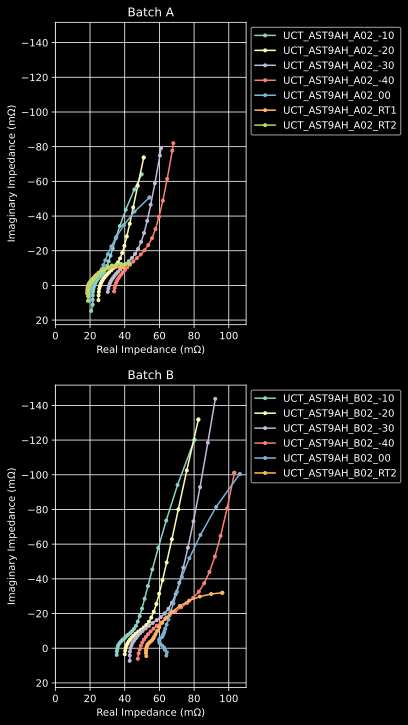

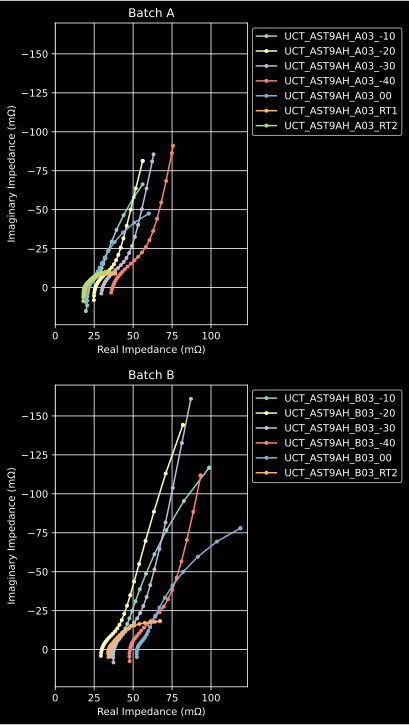

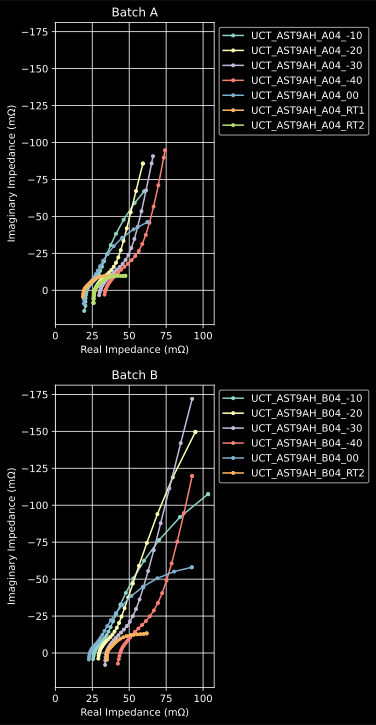

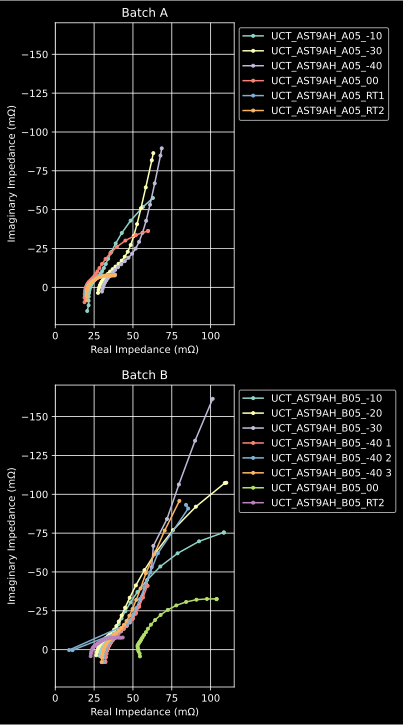

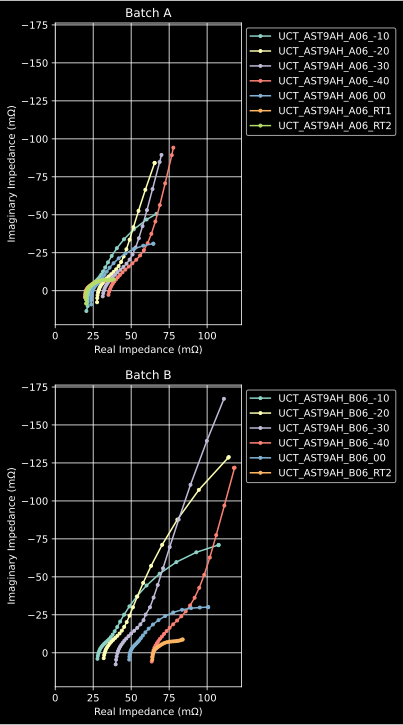

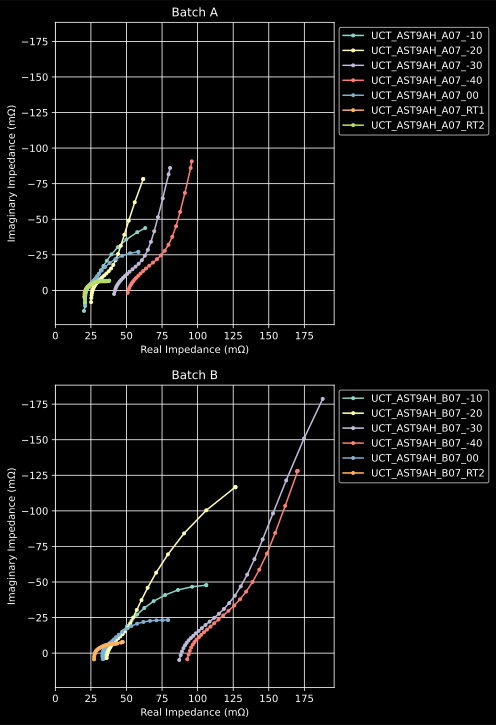

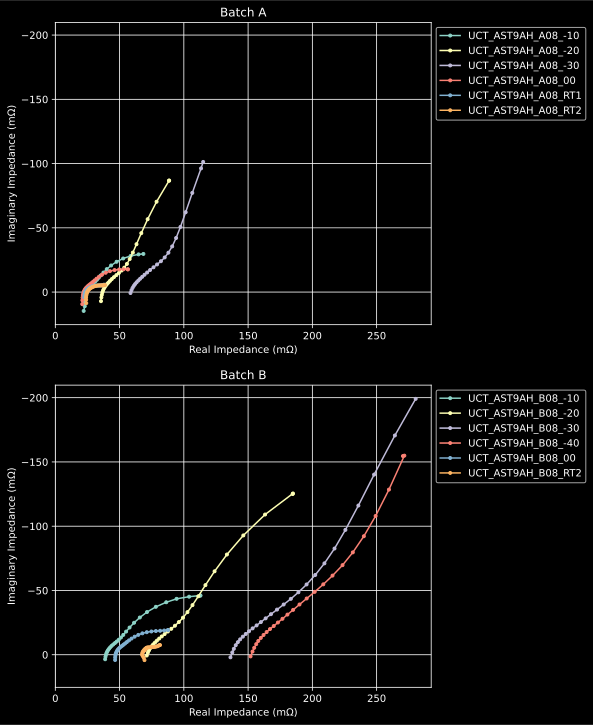

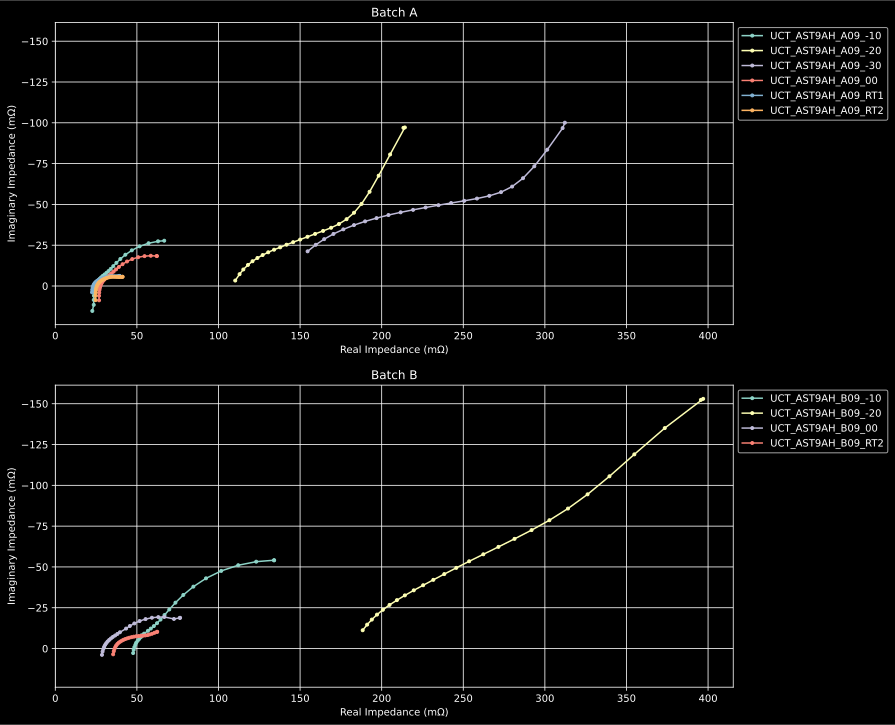

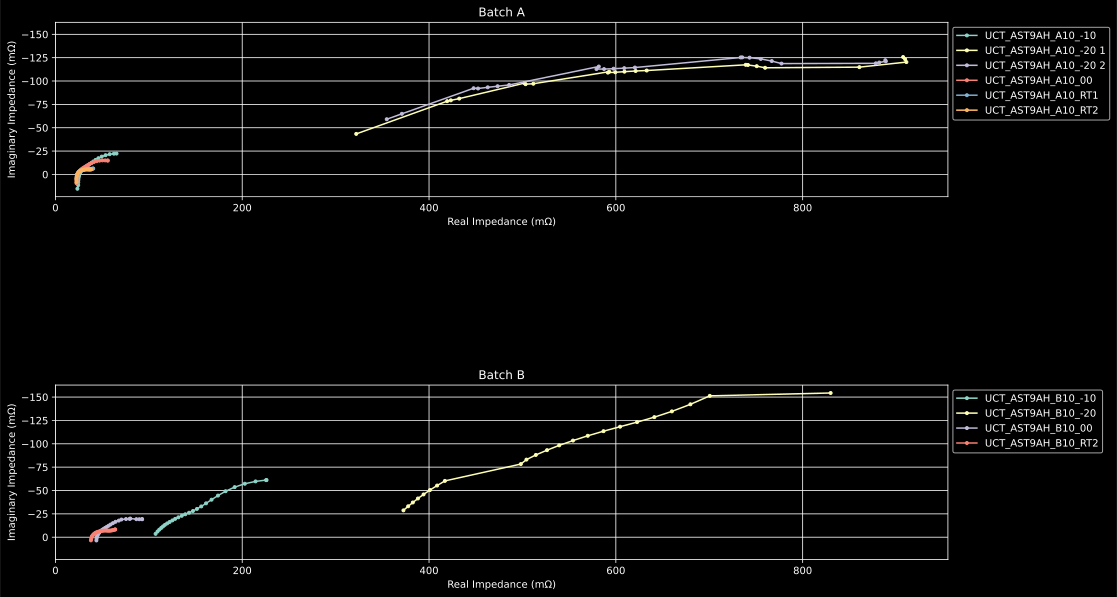

In [9]:
from matplotlib.figure import Figure
from eisAnalysis import splitByBatteryNumber, splitByBatch, getSoC

eisByBattery = splitByBatteryNumber(eis)


def plotConstSoCVariedTempNyquistBatchComparison(
    eisByBattery: Dict[str, Dict[str, EisData]],
    battery: str,
    saveDir: str,
) -> Figure | None:
    batchSplit = splitByBatch(eisByBattery[battery])

    fig, ax = plt.subplots(2, 1, figsize=(18, 20), sharey=True)

    for batch in batchSplit:
        plotNyquist(
            batchSplit[batch],
            title=f"Batch {batch}",
            ax=ax[0] if batch == "A" else ax[1],
        )

    ax[0].legend(loc="upper left", bbox_to_anchor=(1, 1))
    ax[1].legend(loc="upper left", bbox_to_anchor=(1, 1))

    ax[0].invert_yaxis()  # Shared y-axis nulled double inversion in plotNyquist
    (
        ax[0].set_xlim(ax[1].get_xlim())
        if ax[0].get_xlim() < ax[1].get_xlim()
        else ax[1].set_xlim(ax[0].get_xlim())
    )

    fig.savefig(
        f"{saveDir}/{battery}.png",
        transparent=True,
    )

    return fig


saveDir = "../Plots/EIS/Analysis/ConstSoCVariedTemp"
os.makedirs(saveDir, exist_ok=True)
for battery in eisByBattery:
    with concurrent.futures.ThreadPoolExecutor() as executor:
        executor.submit(
            plotConstSoCVariedTempNyquistBatchComparison,
            eisByBattery,
            battery,
            saveDir,
        )
